<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Explainability_Brain_Tumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brain Tumor MRI Dataset
SRC: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [6]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Dataloader

In [8]:
import os
import sys
import argparse
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms


def get_arguments():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=10, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=4, help='number classes')
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()
    return args

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

if __name__ == '__main__':
    args = get_arguments()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    train_dataset = datasets.ImageFolder(root='/content/braintumor/Training', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    test_dataset = datasets.ImageFolder(root='/content/braintumor/Testing', transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ]))

    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset))
    print(train_dataset.class_to_idx)

    model = models.resnet34(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, betas=(0.9, 0.999), weight_decay=0.1)
    criterion = nn.CrossEntropyLoss()

    best_epoch, best_acc = 0.0, 0
    for epoch in range(args.num_epoch):
        train(model, trainloader, criterion, optimizer)
        accuracy = test(model, testloader)
        if accuracy > best_acc:
            patience = 0
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth.tar')
        print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))


Training on: cuda train sample size: 5712 test sample size: 1311
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


#Explainability:LIME

In [26]:
!pip -q install lime

  Preparing metadata (setup.py) ... done


Download pretrained weights

In [43]:
import gdown
!mkdir myweights
url = 'https://drive.google.com/uc?id=19GYVgCz9wjO4wdCmFWhUw9_Uylzylfqe'
gdown.download(url,'myweights/best_model.pth.tar',quiet=True)

'myweights/best_model.pth.tar'

  0%|          | 0/1500 [00:00<?, ?it/s]

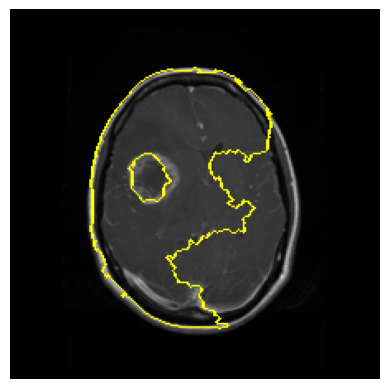

In [46]:
import matplotlib.pyplot as plt
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries


def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((224, 224)),
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model.to(device)
model.load_state_dict(torch.load('best_model.pth.tar'))
model.eval()

img = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg')
# img = Image.open('/content/braintumor/Testing/glioma/Te-glTr_0007.jpg')
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=2,
                                         hide_color=0,
                                         num_samples=1500)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('OFF');

(-0.5, 223.5, 223.5, -0.5)

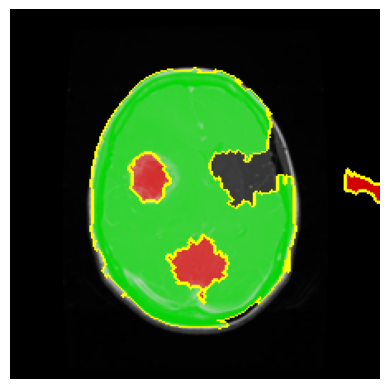

In [42]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
plt.axis('OFF')

#Explainability:SHAP

In [44]:
!pip -q install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.5 MB/s eta 0:00:00


Prepare data

In [2]:
import numpy as np
import torch
import torchvision

# Prepare data transformation pipeline

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x


def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform = [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean=(-1 * np.array(mean) / np.array(std)).tolist(),
        std=(1 / np.array(std)).tolist(),
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)


In [54]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import shap

def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output


class_names = list(test_dataset.class_to_idx.keys())
img0 = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg')
img1 = Image.open('/content/braintumor/Testing/glioma/Te-glTr_0007.jpg')
imgs = np.stack([np.array(img0), np.array(img1)])
Xtr = transform(torch.Tensor(imgs))
out = predict(Xtr)
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

Classes: [0 0]: ['glioma' 'glioma']


Classes: [0 0]: ['glioma' 'glioma']


  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:28, 208.88s/it]              


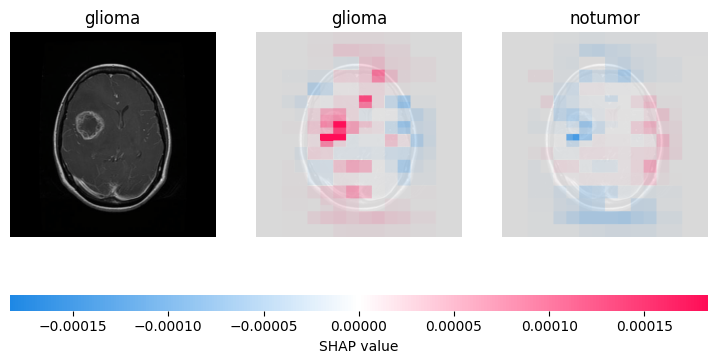

In [6]:
import numpy as np
import torch
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
from PIL import Image

def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

topk = 2
batch_size = 50
n_evals = 10000
class_names = list(test_dataset.class_to_idx.keys())

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model.to(device)
model.load_state_dict(torch.load('/content/myweights/best_model.pth.tar'))
model.eval()


img0 = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg')
img1 = Image.open('/content/braintumor/Testing/glioma/Te-glTr_0007.jpg')
imgs = np.stack([np.array(img0), np.array(img1)])
Xtr = transform(torch.Tensor(imgs))
out = predict(Xtr)
classes = torch.argmax(out, axis=1).cpu().numpy()
print(f"Classes: {classes}: {np.array(class_names)[classes]}")

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", Xtr[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    Xtr[0:1],
    max_evals=n_evals,
    batch_size=batch_size,
    outputs=shap.Explanation.argsort.flip[:topk],
)

shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0]
shap_values.values = [val for val in np.moveaxis(shap_values.values[0], -1, 0)]

shap.image_plot(
    shap_values=shap_values.values,
    pixel_values=shap_values.data,
    labels=shap_values.output_names,
    true_labels=[class_names[0]],
)